# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
pip install hvplot

In [2]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [3]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [5]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [6]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [7]:
# Sanity check
df

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078
...,...,...
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531


In [8]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X first 5 values:\n{X[:5]} \n")
print (f"y first 5 values:\n{y[:5]}")

X first 5 values:
[[9114.719727 8870.820313 9251.269531 8218.049805 6937.080078 7701.25
  7592.720215 8260.69043  8696.830078 8569.290039]
 [8870.820313 9251.269531 8218.049805 6937.080078 7701.25     7592.720215
  8260.69043  8696.830078 8569.290039 8084.609863]
 [9251.269531 8218.049805 6937.080078 7701.25     7592.720215 8260.69043
  8696.830078 8569.290039 8084.609863 8911.269531]
 [8218.049805 6937.080078 7701.25     7592.720215 8260.69043  8696.830078
  8569.290039 8084.609863 8911.269531 8544.69043 ]
 [6937.080078 7701.25     7592.720215 8260.69043  8696.830078 8569.290039
  8084.609863 8911.269531 8544.69043  9485.639648]] 

y first 5 values:
[[ 8084.609863]
 [ 8911.269531]
 [ 8544.69043 ]
 [ 9485.639648]
 [10033.75    ]]


In [10]:
print(f"len(X): {len(X)} \n")
print(f"len(y): {len(y)}")

len(X): 532 

len(y): 532


In [11]:
# Use 70% of the data for training and the remaineder for testing

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [12]:
# Sanity check
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

[[9114.719727 8870.820313 9251.269531 8218.049805 6937.080078 7701.25
  7592.720215 8260.69043  8696.830078 8569.290039]
 [8870.820313 9251.269531 8218.049805 6937.080078 7701.25     7592.720215
  8260.69043  8696.830078 8569.290039 8084.609863]
 [9251.269531 8218.049805 6937.080078 7701.25     7592.720215 8260.69043
  8696.830078 8569.290039 8084.609863 8911.269531]
 [8218.049805 6937.080078 7701.25     7592.720215 8260.69043  8696.830078
  8569.290039 8084.609863 8911.269531 8544.69043 ]
 [6937.080078 7701.25     7592.720215 8260.69043  8696.830078 8569.290039
  8084.609863 8911.269531 8544.69043  9485.639648]]
[[3685.139893 3611.340088 3617.409912 3605.870117 3588.719971 3593.48999
  3617.23999  3670.919922 3670.919922 3912.570068]
 [3611.340088 3617.409912 3605.870117 3588.719971 3593.48999  3617.23999
  3670.919922 3670.919922 3912.570068 3924.23999 ]
 [3617.409912 3605.870117 3588.719971 3593.48999  3617.23999  3670.919922
  3670.919922 3912.570068 3924.23999  3974.050049]
 [3605

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
# Sanity check
X_train[:3]

array([[0.60761794, 0.58242373, 0.62172321, 0.51499412, 0.38267307,
        0.46160996, 0.4503991 , 0.5193988 , 0.56445096, 0.55127638],
       [0.58242373, 0.62172321, 0.51499412, 0.38267307, 0.46160996,
        0.4503991 , 0.5193988 , 0.56445096, 0.55127638, 0.5012101 ],
       [0.62172321, 0.51499412, 0.38267307, 0.46160996, 0.4503991 ,
        0.5193988 , 0.56445096, 0.55127638, 0.5012101 , 0.58660203]])

In [15]:
X_train.shape

(372, 10)

In [16]:
X_train.shape[0]

372

In [17]:
X_train.shape[1]

10

In [18]:
# Reshape the features for the model
# Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]]] 

X_test sample values:
[[[0.04675556]
  [0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]]

 [[0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]
  [0.07145402]]]


## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [21]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [22]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [23]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
372/372 [==============================] - 6s 8ms/step - loss: 0.0580
Epoch 2/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0503
Epoch 3/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0618
Epoch 4/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0628
Epoch 5/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0528
Epoch 6/10
372/372 [==============================] - 2s 7ms/step - loss: 0.0473
Epoch 7/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0454
Epoch 8/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0366
Epoch 9/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0362
Epoch 10/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0355


## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [24]:
# Evaluate the model
# Use the evaluate method using the testing data.

model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 5ms/step - loss: 0.0616


0.06157752871513367

In [25]:
# Make some predictions
# Make some closing price predictions using LSTM RNN model and testing data.

predicted = model.predict(X_test)

In [26]:
# Recover the original prices instead of the scaled version
# Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3798.663330
2019-02-21,3974.050049,3825.530762
2019-02-22,3937.040039,3858.692139
2019-02-23,3983.530029,3890.683105
2019-02-24,4149.089844,3919.226074


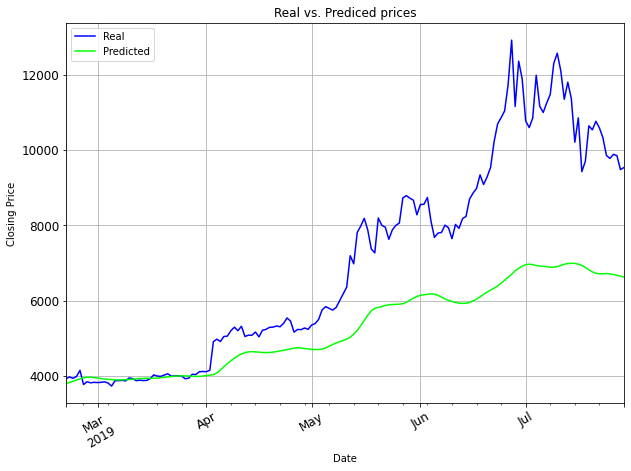

In [28]:
# Plot the real vs predicted values as a line chart

stocks.plot(figsize = (10, 7), fontsize=12, rot=30, title = "Real vs. Prediced prices", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

In [29]:
from sklearn.metrics import mean_squared_error

# calculating the root mean squared error regression loss.(squared=False)
mean_squared_error(real_prices, predicted_prices, squared=False)

2402.265750063454

## Trying different window size=5

In [30]:
# Predict Closing Prices using a 5 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X first 5 values:\n{X[:5]} \n")
print (f"y first 5 values:\n{y[:5]}")

X first 5 values:
[[9114.719727 8870.820313 9251.269531 8218.049805 6937.080078]
 [8870.820313 9251.269531 8218.049805 6937.080078 7701.25    ]
 [9251.269531 8218.049805 6937.080078 7701.25     7592.720215]
 [8218.049805 6937.080078 7701.25     7592.720215 8260.69043 ]
 [6937.080078 7701.25     7592.720215 8260.69043  8696.830078]] 

y first 5 values:
[[7701.25    ]
 [7592.720215]
 [8260.69043 ]
 [8696.830078]
 [8569.290039]]


In [31]:
print(f"len(X): {len(X)} \n")
print(f"len(y): {len(y)}")

len(X): 537 

len(y): 537


In [32]:
# Use 70% of the data for training and the remaineder for testing
# To avoid the dataset being randomized, we will manually split the data using array slicing.
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [33]:
# Sanity check
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

[[9114.719727 8870.820313 9251.269531 8218.049805 6937.080078]
 [8870.820313 9251.269531 8218.049805 6937.080078 7701.25    ]
 [9251.269531 8218.049805 6937.080078 7701.25     7592.720215]
 [8218.049805 6937.080078 7701.25     7592.720215 8260.69043 ]
 [6937.080078 7701.25     7592.720215 8260.69043  8696.830078]]
[[3605.870117 3588.719971 3593.48999  3617.23999  3670.919922]
 [3588.719971 3593.48999  3617.23999  3670.919922 3670.919922]
 [3593.48999  3617.23999  3670.919922 3670.919922 3912.570068]
 [3617.23999  3670.919922 3670.919922 3912.570068 3924.23999 ]
 [3670.919922 3670.919922 3912.570068 3924.23999  3974.050049]]
[[7701.25    ]
 [7592.720215]
 [8260.69043 ]
 [8696.830078]
 [8569.290039]]
[[3670.919922]
 [3912.570068]
 [3924.23999 ]
 [3974.050049]
 [3937.040039]]


In [34]:
# Use the MinMaxScaler to scale data between 0 and 1.
# scale both features and target sets.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [35]:
# Sanity check
X_train[:3]

array([[0.60761794, 0.58242373, 0.62172321, 0.51499412, 0.38267307],
       [0.58242373, 0.62172321, 0.51499412, 0.38267307, 0.46160996],
       [0.62172321, 0.51499412, 0.38267307, 0.46160996, 0.4503991 ]])

In [36]:
X_train.shape

(375, 5)

In [37]:
X_train.shape[0]

375

In [38]:
X_train.shape[1]

5

In [39]:
# The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need 
# to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).
# Reshape the features for the model
# Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]]] 

X_test sample values:
[[[0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]]

 [[0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]]]


In [40]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [41]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")


In [42]:
# Summarize the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [43]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
375/375 [==============================] - 5s 5ms/step - loss: 0.0709
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0406
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0481
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0502
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0460
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0366
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0273
Epoch 8/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0248
Epoch 9/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0255
Epoch 10/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0207


In [44]:
# Evaluate the model
# Use the evaluate method using the testing data.

model.evaluate(X_test, y_test)


6/6 [==============================] - 1s 3ms/step - loss: 0.0459


0.045930519700050354

In [45]:
# Make some predictions
# Make some closing price predictions using LSTM RNN model and testing data.

predicted = model.predict(X_test)

In [46]:
# Recover the original prices instead of the scaled version
# Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [47]:
# Create a DataFrame of Real and Predicted values
stocks1 = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()},
     index = df.index[-len(real_prices): ]) 
stocks1.head()

,Real,Predicted
2019-02-18,3670.919922,3807.168457
2019-02-19,3912.570068,3815.262451
2019-02-20,3924.239990,3843.646484
2019-02-21,3974.050049,3887.665771
2019-02-22,3937.040039,3940.775879


In [48]:
# Sanity check
stocks1

,Real,Predicted
2019-02-18,3670.919922,3807.168457
2019-02-19,3912.570068,3815.262451
2019-02-20,3924.239990,3843.646484
2019-02-21,3974.050049,3887.665771
2019-02-22,3937.040039,3940.775879
...,...,...
2019-07-25,9772.139648,7203.095703
2019-07-26,9882.429688,7174.447754
2019-07-27,9847.450195,7119.458008
2019-07-28,9478.320313,7068.818848


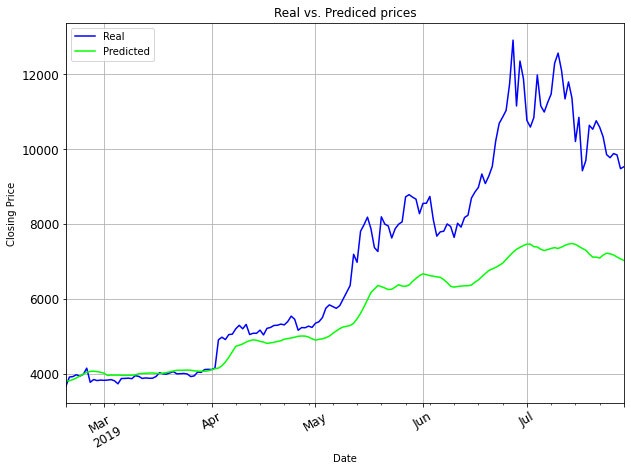

In [49]:
# Plot the real vs predicted values as a line chart

stocks1.plot(figsize = (10, 7), fontsize=12, rot=30, title = "Real vs. Prediced prices", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

In [50]:
from sklearn.metrics import mean_squared_error

# calculating the root mean squared error regression loss.(squared=False)
mean_squared_error(real_prices, predicted_prices, squared=False)

2074.7252363181788

# BONUS 1: function to experiment with different window size from 1 to 10

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

recurr = []
for i in range(1,11):
  window_size = i
  print()
  print(f"*************************This is the model with window_size:{i}*************************")

  # Column index 0 is the 'fng_value' column
  # Column index 1 is the `Close` column
  feature_column = 1
  target_column = 1
  X, y = window_data(df, window_size, feature_column, target_column)

  # Use 70% of the data for training and the remaineder for testing
  # To avoid the dataset being randomized, we will manually split the data using array slicing.
  # Use 70% of the data for training and the remainder for testing
  split = int(0.7 * len(X))
  X_train = X[: split]
  X_test = X[split:]
  y_train = y[: split]
  y_test = y[split:]

  # Use the MinMaxScaler to scale data between 0 and 1.
  # scale both features and target sets.
  scaler = MinMaxScaler()
  scaler.fit(X)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  scaler.fit(y)
  y_train = scaler.transform(y_train)
  y_test = scaler.transform(y_test)

  # The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need 
  # to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).
  # Reshape the features for the model
  # Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Build the LSTM model. 
  # The return sequences need to be set to True if you are adding additional LSTM layers, but 
  # You don't have to do this for the final layer. 
  # Note: The dropouts help prevent overfitting
  # Note: The input shape is the number of time steps and the number of indicators
  # Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

  # Define the LSTM RNN model.
  model = Sequential()

  number_units = 30
  dropout_fraction = 0.2

  # Layer 1
  model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(dropout_fraction))
  # Layer 2
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 3
  model.add(LSTM(units=number_units))
  model.add(Dropout(dropout_fraction))
  # Output layer
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer="adam", loss="mean_squared_error")

  # Summarize the model
  model.summary()

  # Train the model
  # Use at least 10 epochs
  # Do not shuffle the data
  # Experiement with the batch size, but a smaller batch size is recommended
  model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)
  
  # Evaluate the model
  # Use the evaluate method using the testing data.
  model.evaluate(X_test, y_test)

 
  # Make some closing price predictions using LSTM RNN model and testing data.
  predicted = model.predict(X_test)
  
  # Recover the original prices instead of the scaled version
  # Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.
  predicted_prices = scaler.inverse_transform(predicted)
  real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
  

  # calculating the root mean squared error regression loss.(squared=False)
  root_mse = mean_squared_error(real_prices, predicted_prices, squared=False)
 
  
  recurr.append({
    "window_size": i,
    "model": "LSTM",
    "summery":model.summary(),
    "evaluate":model.evaluate(X_test, y_test),
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
    "root_mse": root_mse,
    "real_prices": real_prices,
    "index": df.index[-len(real_prices): ]
    })


*************************This is the model with window_size:1*************************
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 30)             3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
________________________________

#BONUS 2: function to display the real vs predicted closing price by different window size

window_size:1 Real vs. Predicted closing prices


,Real,Predicted
2019-02-17,3670.919922,3559.816162
2019-02-18,3670.919922,3596.482666
2019-02-19,3912.570068,3596.482666
2019-02-20,3924.239990,3761.666748
2019-02-21,3974.050049,3769.647949




window_size:2 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,3517.205322
2019-02-19,3912.570068,3551.259766
2019-02-20,3924.239990,3604.789551
2019-02-21,3974.050049,3759.016846
2019-02-22,3937.040039,3777.234863




window_size:3 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,3544.149170
2019-02-19,3912.570068,3570.351562
2019-02-20,3924.239990,3626.042969
2019-02-21,3974.050049,3699.176758
2019-02-22,3937.040039,3810.737305




window_size:4 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,3696.158936
2019-02-19,3912.570068,3712.288330
2019-02-20,3924.239990,3750.884521
2019-02-21,3974.050049,3807.741699
2019-02-22,3937.040039,3870.959717




window_size:5 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,3898.773926
2019-02-19,3912.570068,3905.829102
2019-02-20,3924.239990,3931.106689
2019-02-21,3974.050049,3970.678223
2019-02-22,3937.040039,4018.810547




window_size:6 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,3573.092041
2019-02-20,3924.239990,3593.425049
2019-02-21,3974.050049,3628.818848
2019-02-22,3937.040039,3673.527588
2019-02-23,3983.530029,3718.310303




window_size:7 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,3878.525146
2019-02-20,3924.239990,3900.843018
2019-02-21,3974.050049,3933.781250
2019-02-22,3937.040039,3971.784424
2019-02-23,3983.530029,4005.294678




window_size:8 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,3757.759766
2019-02-20,3924.239990,3771.657959
2019-02-21,3974.050049,3793.718018
2019-02-22,3937.040039,3822.005371
2019-02-23,3983.530029,3851.335205




window_size:9 Real vs. Predicted closing prices


,Real,Predicted
2019-02-20,3924.239990,3819.917725
2019-02-21,3974.050049,3845.246826
2019-02-22,3937.040039,3875.563477
2019-02-23,3983.530029,3904.700928
2019-02-24,4149.089844,3931.595703




window_size:10 Real vs. Predicted closing prices


,Real,Predicted
2019-02-20,3924.239990,3791.169434
2019-02-21,3974.050049,3821.917725
2019-02-22,3937.040039,3858.797607
2019-02-23,3983.530029,3892.912598
2019-02-24,4149.089844,3922.685303


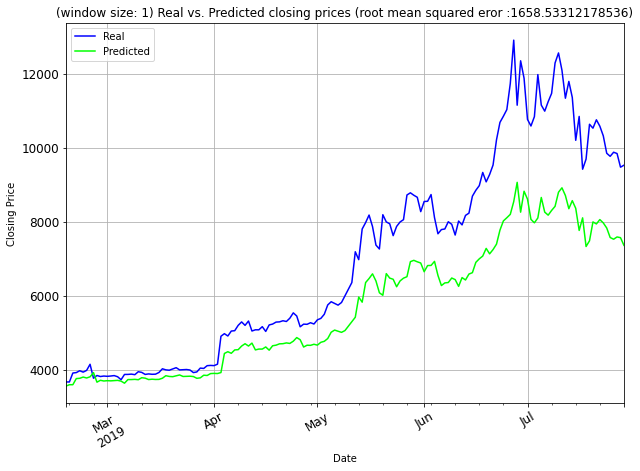

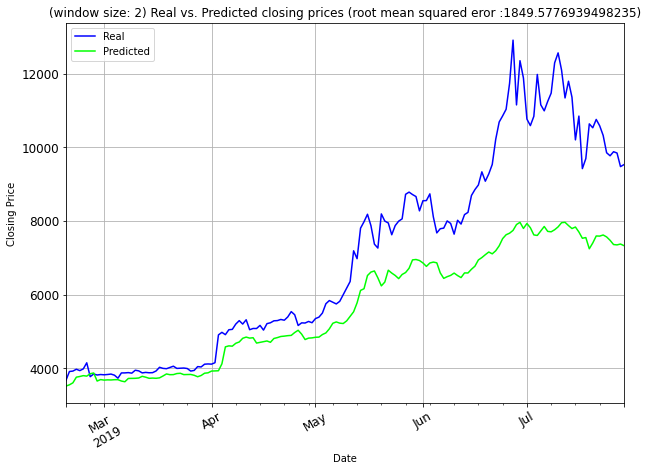

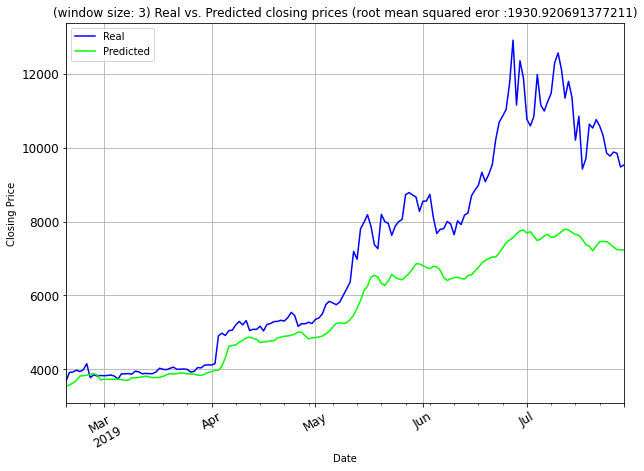

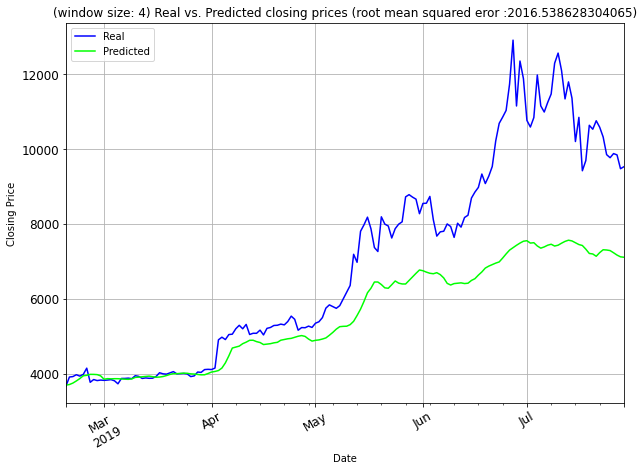

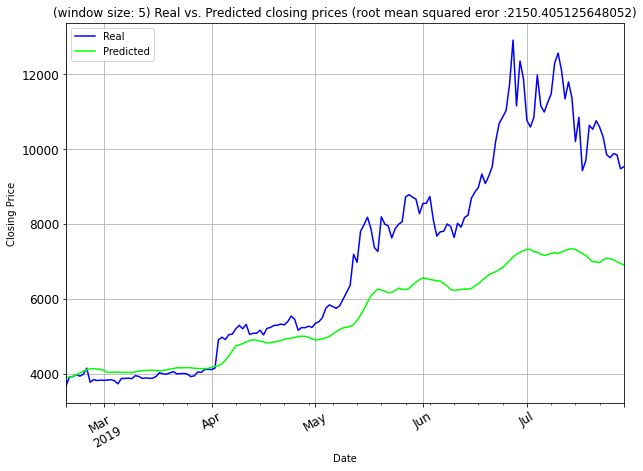

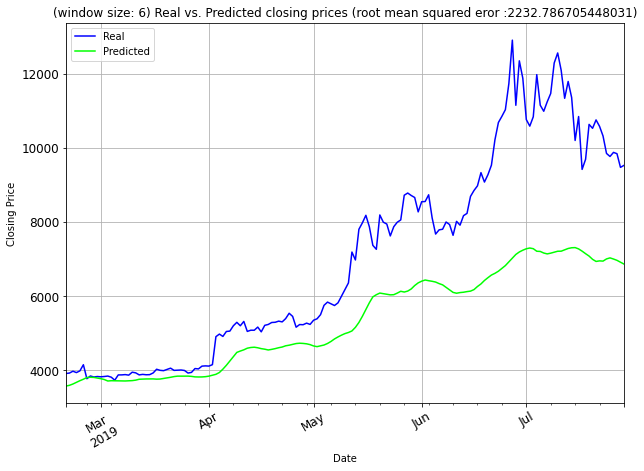

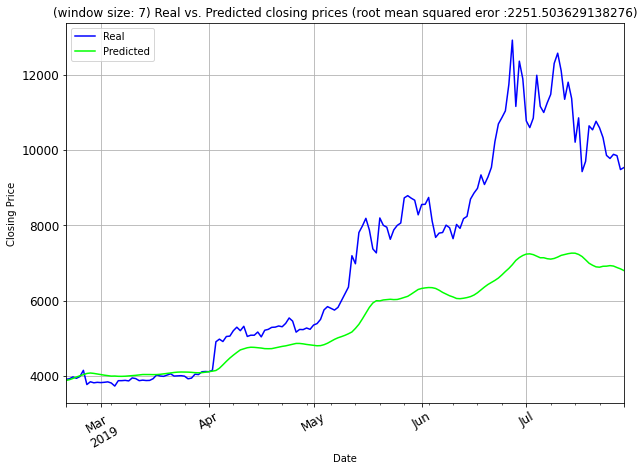

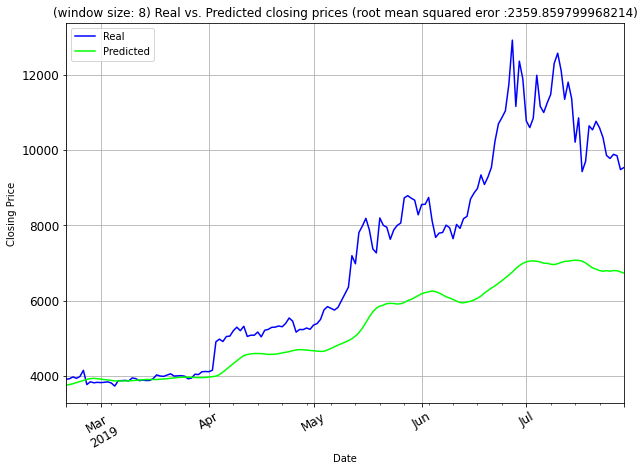

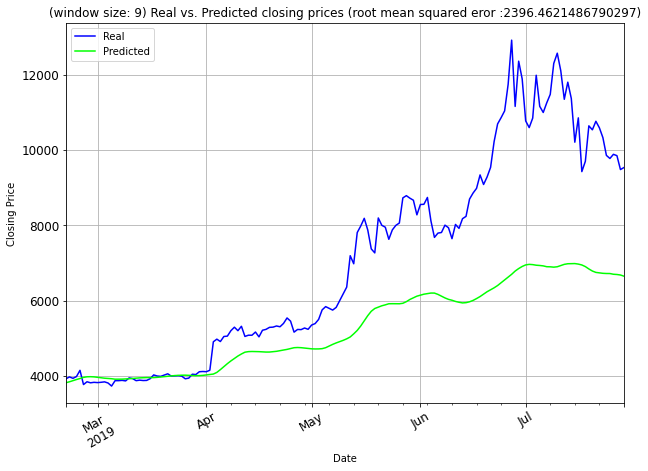

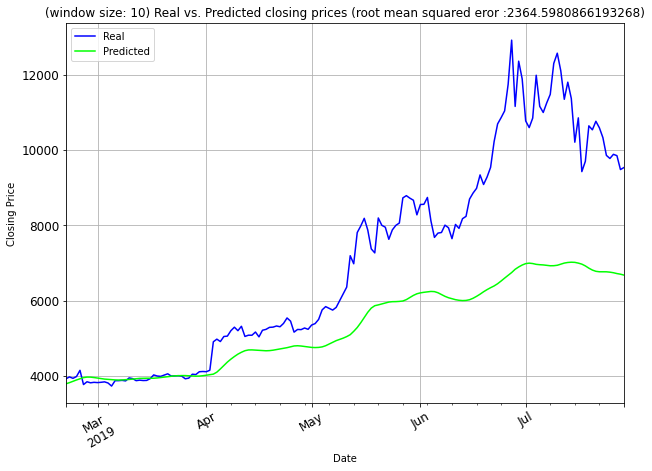

In [52]:
from IPython.display import display

plots_v = [] #save the plot as figure using the previous homework making dashboard, and then append each figure in to plost_v list and use those figure variables to make the dashboard.
for x in recurr:
  print(f"window_size:{x['window_size']} Real vs. Predicted closing prices")
  n_df = pd.DataFrame({"Real":x["Real"], "Predicted":x["Predicted"]}, index=x["index"])
  display(n_df.head())
  print()
  print()
  
  # Plot the real vs predicted values as a line chart
  n_df.plot(figsize = (10, 7), fontsize=12, rot=30, title = f"(window size: {x['window_size']}) Real vs. Predicted closing prices (root mean squared eror :{x['root_mse']})", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

#BONUS 3: function to display the root mean squared error vs window size

,window,rmse
0,1,1658.533122
1,2,1849.577694
2,3,1930.920691
3,4,2016.538628
4,5,2150.405126
5,6,2232.786705
6,7,2251.503629
7,8,2359.859800
8,9,2396.462149
9,10,2364.598087


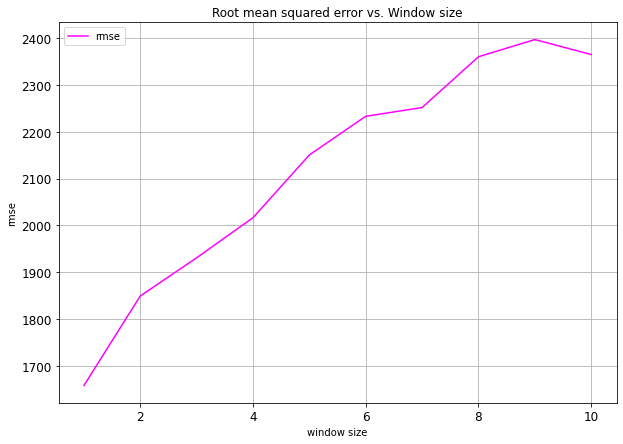

In [53]:
rmse = []
window = []
for x in recurr:
  rmse.append(x["root_mse"])
  window.append(x["window_size"])
  n_df2 = pd.DataFrame({"window":window, "rmse":rmse}) 

display(n_df2)

# Plot the window size vs root mean squared error as a line chart
n_df2.plot(x="window", y="rmse",  figsize = (10, 7), fontsize=12, rot=0, title = "Root mean squared error vs. Window size", 
            xlabel="window size", ylabel="rmse", grid=True, colormap='spring')

# Evaluate the performance of each model
Finally, use the testing data to evaluate each model and compare the performance.
Use the above to answer the following:

- Which model has a lower loss?

**Answer : the model with window size 5 days has a lower loss compared to the model with window size 10 days.**

- Which model tracks the actual values better over time?

**Answer : the model with window size 5 days tracks the actual values better over time compared to the model with window size 10 days.**

- Which window size works best for the model?

**Answer : window size 5 days works best for the model compared to the window size 10 days.**

# Conclusion

**Based on the results above considering the root(squared=False) mean squared error, window size 5 days is better than window size 10 days. Overall, compared to the model using FNG values as feature, this model using the previous closing prices as feature is better to predict the next closing price, based on the root mean squared error of each model.**

Considering the BONUS functions, the model generates different rmse compared to the model I ran without using the BONUS functions for some reasons. With BONUS functions, as shown on the chart above "rmse vs. window size", window size 5 has smaller rmse compared to window size 10. Overall, the model using closing price as feature shows increase in rmse by increased window size unlike the model using fng as feature.